# Investigating adjusted p-values from eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 26, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney control samples. The phenotype used for the eQTL analysis was gene expression TPM values. These were also the values used to filter out lowly expressed genes.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [2]:
library(dplyr)
library(qvalue)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/control_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/control_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [3]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

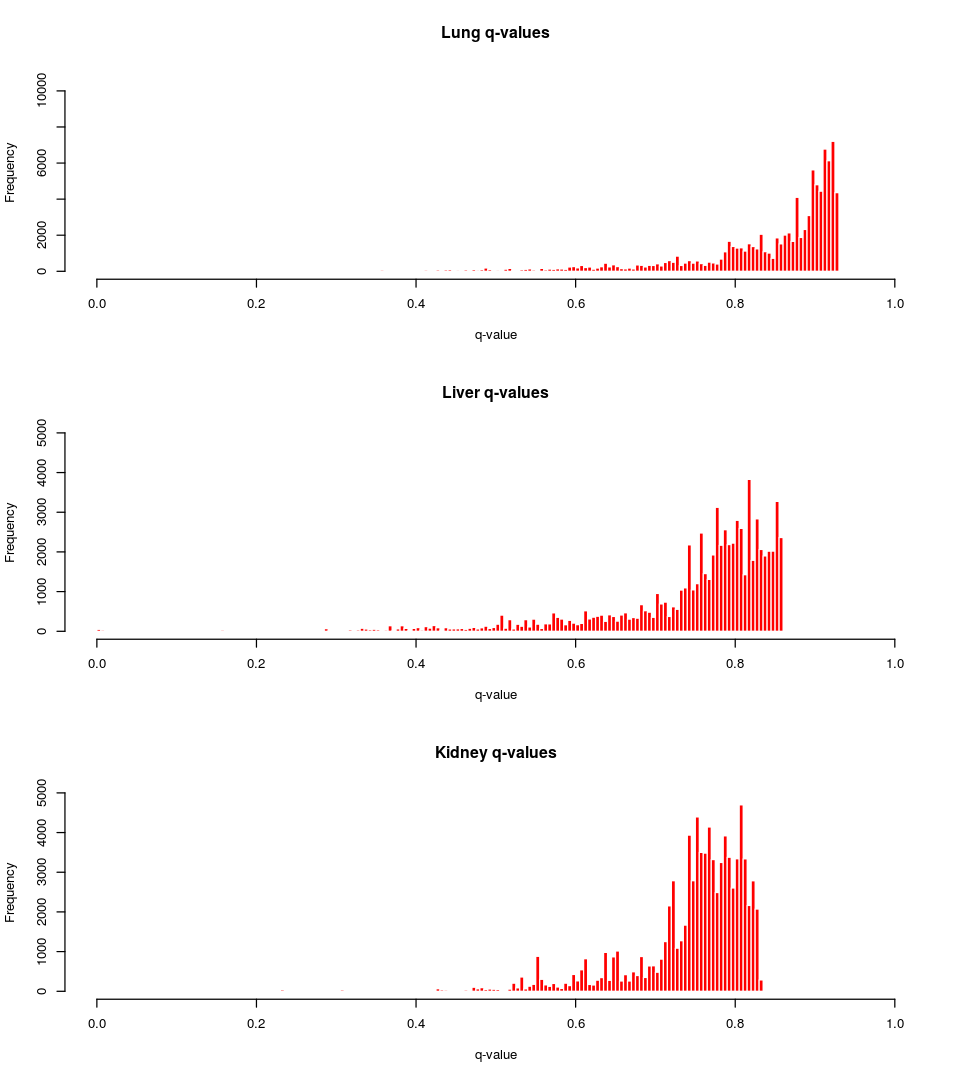

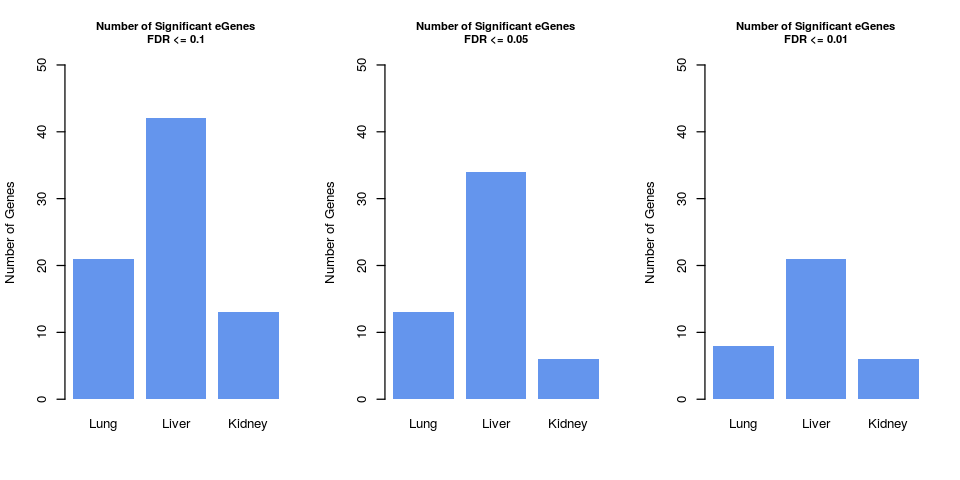

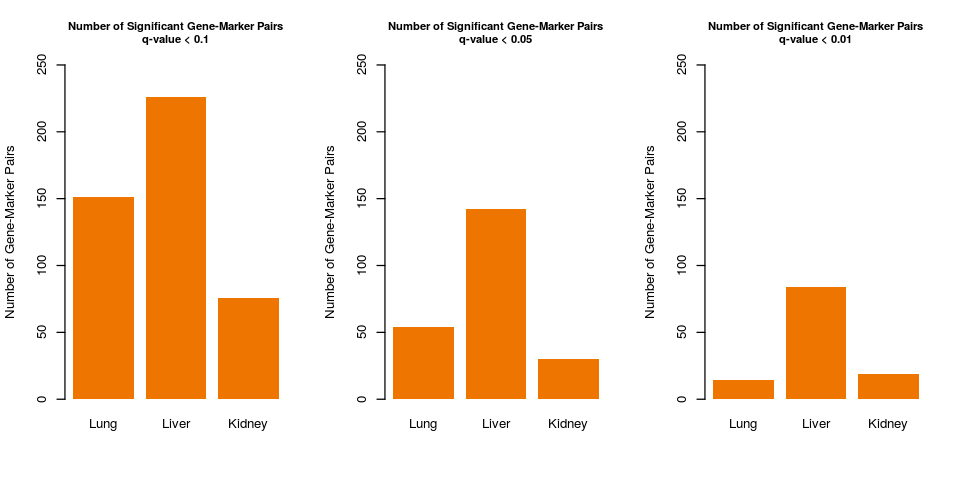

In [5]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,11000), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,50),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [6]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/control_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/control_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene          marker                                chr   start    
34336 Syne4         UNC12572462.UNC12573732               chr7  31229864 
34158 Rbm42         UNC12549403.UNC12567534               chr7  29589840 
34253 Rbm42         JAX00149774.UNC12572046               chr7  30938928 
34335 Sipa1l3       UNC12572462.UNC12573732               chr7  31229864 
11359 Gm14288       UNC4556542.UNC4558476                 chr2  174406645
11381 Gm14288       JAX00512370.UNC4561324                chr2  174571924
34334 Sdhaf1        UNC12572462.UNC12573732               chr7  31229864 
34264 Tbcb          JAX00149774.UNC12572046               chr7  30938928 
34173 Tbcb          UNC12549403.UNC12567534               chr7  29589840 
72419 Mir7212       UNC25181010.UNC25220921               chr15 22446827 
34315 Kmt2b         UNC12572462.UNC12573732               chr7  31229864 
74999 4930578M01Rik UNC26205052.UNC26205386               chr15 98891389 
14510 Phtf1os       UNC5891025.UNC5893973                 chr3  104575861
14481 Phtf1os       UNC5888495.UNC030164357               chr3  104381592
13377 Gon4l         UNC5732520.UNC5752814                 chr3  88658882 
51176 Psap          UNC18062560.UNC18062560               chr10 60430189 
51200 Psap          UNC18063481.JAX00195688               chr10 60499764 
51236 Psap          backupJAX00290606.backupJAX00290771   chr10 60619741 
34302 Fxyd5         UNC12572462.UNC12573732               chr7  31229864 
51129 Psap          UNC18061032.UNC18061957               chr10 60315145 
51153 Psap          UNC18062005.UNC18062389               chr10 60393195 
51026 Psap          UNC18034355.JAX00290458               chr10 58371317 
51052 Psap          UNC18049832.JAX00290510               chr10 59489615 
51079 Psap          UNC18055450.JAX00018577               chr10 59906332 
51104 Psap          UNC18060895.UNC18060895               chr10 60303179 
14450 Phtf1os       UNC5882459.UNC5888276                 chr3  103483523
13285 Gon4l         UNC5724119.backupJAX00110129          chr3  87765839 
13213 Gon4l         UNC5722551.UNC5723775                 chr3  87571343 
34062 Sertad1       UNC12543724.UNC12548710               chr7  29110157 
34304 Gapdhs        UNC12572462.UNC12573732               chr7  31229864 
⋮     ⋮             ⋮                                     ⋮     ⋮        
83223 Tmem178       UNC28423410.UNC28432315               chr17 79832145 
34347 Zfp260        UNC12572462.UNC12573732               chr7  31229864 
13240 Smg5          UNC5722551.UNC5723775                 chr3  87571343 
83364 Cox7a2l       UNC28471365.UNC28471365               chr17 82962604 
13334 Ube2q1        UNC5724119.backupJAX00110129          chr3  87765839 
66557 Slc17a2       UNC22267867.UNC22282237               chr13 24047749 
34176 Tyrobp        UNC12549403.UNC12567534               chr7  29589840 
83955 4930426D05Rik UNC28851094.UNC28857894               chr18 20993235 
83430 Cox7a2l       UNC28488936.UNC28488936               chr17 84150329 
66651 Foxf2         UNC22359905.UNC22369547               chr13 31216996 
13467 Ubap2l        UNC5732520.UNC5752814                 chr3  88658882 
13356 Chtop         UNC5732520.UNC5752814                 chr3  88658882 
13135 Smg5          backupUNC030491543.backupUNC030491543 chr3  87526958 
34194 Zfp59         UNC12549403.UNC12567534               chr7  29589840 
34033 Gmfg          UNC12543724.UNC12548710               chr7  29110157 
34266 Tyrobp        JAX00149774.UNC12572046               chr7  30938928 
34339 Tyrobp        UNC12572462.UNC12573732               chr7  31229864 
33962 Gmfg          UNC12543518.UNC12543518               chr7  29082051 
41735 Pdgfrl        JAX00666596.UNC14627018               chr8  41705731 
33887 Gmfg          UNC12542093.UNC12543129               chr7  28910807 
83369 Cox7a2l       UNC28472362.JAX00448271               chr17 83007644 
41716 Pdgfrl        UNC080160446.UNC080183083             chr8  39132611 
13444 Shc1

Liver


gene          marker                       chr   start     end      
47298 Fam20a        UNC20365061.UNC20370504      chr11 109715729 110017118
47314 Fam20a        JAX00031724.JAX00031739      chr11 110023548 110222322
47330 Fam20a        JAX00031740.UNC20377562      chr11 110230687 110415434
47343 Fam20a        UNC20378120.UNC20388460      chr11 110448868 111136321
29775 Cln3          UNC13808080.UNC13808351      chr7  134137007 134181453
17794 N4bp2         UNC9365487.UNC9365487        chr5  66774792  66774792 
17773 N4bp2         UNC9340181.UNC9365328        chr5  64851136  66767906 
29693 Cln3          UNC13807161.UNC13807864      chr7  133997968 134107195
49159 Dock4         UNC20954431.UNC20955852      chr12 40996854  41105657 
49149 Arl4a         UNC20934810.UNC20941479      chr12 39614799  40096267 
49152 Arl4a         UNC20941949.UNC20953816      chr12 40149250  40962416 
49158 Arl4a         UNC20954431.UNC20955852      chr12 40996854  41105657 
11009 Gstm7         UNC030165183.UNC5917724      chr3  105846504 107196597
11046 Gstm7         UNC5918145.UNC5932712        chr3  107231626 108614073
11081 Gstm7         UNC5933128.JAX00533731       chr3  108641303 109161446
33671 Cklf          UNC15417874.UNC15422538      chr8  106499195 106863747
33710 Cklf          UNC15422872.UNC15444168      chr8  106893004 109080134
33648 Cklf          UNC15416961.JAX00679081      chr8  106429699 106464668
49054 Pxdn          UNC20791947.UNC20816738      chr12 29266955  30849891 
49070 Pxdn          UNC20817152.UNC20825770      chr12 30869009  31347187 
10151 Npr1          UNC5732520.UNC5752814        chr3  88658882  91515928 
51990 Fam8a1        UNC22553195.UNC22578692      chr13 47325689  50588947 
5955  G6pc2         UNC3274971.UNC3298947        chr2  69171715  70960464 
10014 Pmf1          UNC5722551.UNC5723775        chr3  87571343  87715529 
10076 Pmf1          UNC5724119.backupJAX00110129 chr3  87765839  88658464 
10154 Pmf1          UNC5732520.UNC5752814        chr3  88658882  91515928 
47347 Prkar1a       UNC20378120.UNC20388460      chr11 110448868 111136321
9977  Pmf1          JAX00110044.UNC5722547       chr3  87537572  87570981 
48990 Grhl1         UNC20742271.JAX00199937      chr12 25878188  25907076 
47335 Prkar1a       JAX00031740.UNC20377562      chr11 110230687 110415434
⋮     ⋮             ⋮                            ⋮     ⋮         ⋮        
68821 Hnrnpul2      UNC29870739.UNC29870739      chr19 8951909   8951909  
68858 Hnrnpul2      UNC29870891.UNC29870891      chr19 8963267   8963267  
68895 Hnrnpul2      UNC29870993.UNC29871077      chr19 8975822   8990729  
68933 Hnrnpul2      UNC29871139.UNC29871202      chr19 9001604   9011153  
68971 Hnrnpul2      UNC29871338.UNC29871338      chr19 9028051   9028051  
69009 Hnrnpul2      UNC29871426.UNC29871426      chr19 9037801   9037801  
69047 Hnrnpul2      UNC29871593.UNC29871593      chr19 9054951   9054951  
69085 Hnrnpul2      UNC29871907.JAX00470016      chr19 9096225   9111146  
47371 Fam104a       UNC20415153.UNC20418686      chr11 112578874 112782357
52003 Nol8          UNC22553195.UNC22578692      chr13 47325689  50588947 
10101 2810403A07Rik UNC5732520.UNC5752814        chr3  88658882  91515928 
52024 Nol8          UNC22578796.UNC22595965      chr13 50622298  52163074 
17777 Rbm47         UNC9340181.UNC9365328        chr5  64851136  66767906 
17797 Rbm47         UNC9365487.UNC9365487        chr5  66774792  66774792 
41326 Slc26a10      UNC18963682.JAX00302406      chr10 127267455 127919711
9981  Rrnad1        JAX00110044.UNC5722547       chr3  87537572  87570981 
41239 Slc26a10      JAX00302230.UNC18963675      chr10 127068725 127267133
49002 Taf1b         JAX00327915.JAX00327915      chr12 25912290  25912290 
6985  Mertk         UNC3932612.UNC3936541        chr2  127471844 127779562
7010  Mertk         UNC3936694.UNC3937293        chr2  127793826 127852483
7035  Mertk         UNC3937526.UNC3940862        chr2  127879752 128176082
42376 Pnpt1         UNC11029658

Kidney


gene          marker                         chr   start     end      
47727 Pmel          JAX00302230.UNC18963675        chr10 127068725 127267133
47819 Pmel          UNC18963682.JAX00302406        chr10 127267455 127919711
47892 Pmel          UNC18970636.UNC101328991       chr10 127924035 128389507
47952 Pmel          JAX00302462.JAX00302527        chr10 128394706 128919120
47984 Pmel          UNC18980143.UNC18983661        chr10 128988719 129385947
23344 Cldn4         UNC10243742.UNC10244171        chr5  136017898 136044478
23223 Cldn4         JAX00136067.UNC10236173        chr5  135371333 135447354
17893 Mir6399       UNC8315971.UNC8323209          chr4  137175105 137665739
41041 Siae          UNC16167936.UNC16176492        chr9  36736917  37377135 
1522  Inpp5d        UNC1067986.JAX00006232         chr1  84177354  88526554 
17922 Mir6399       UNC8323552.UNC8325248          chr4  137691029 137811542
1560  Inpp5d        JAX00258020.UNC1098588         chr1  88609381  90294626 
1594  Inpp5d        UNC1099115.UNC1103435          chr1  90338138  90627755 
57011 Rps7          JAX00034273.UNC20791781        chr12 28286633  29255499 
57022 Rps7          UNC20791947.UNC20816738        chr12 29266955  30849891 
17950 Mir6399       JAX00568384.JAX00568392        chr4  137828373 137840334
17978 Mir6399       UNC8325771.UNC8325771          chr4  137843978 137843978
18010 Mir6399       JAX00568401.UNC8343218         chr4  137851619 139147151
40856 Rpusd4        UNC16139398.JAX00689916        chr9  34191620  34635092 
40845 Rpusd4        UNC16138281.UNC16139042        chr9  34085140  34142881 
66505 Npcd          JAX00406581.UNC25941426        chr15 78344275  78763276 
66562 Npcd          UNC25942378.UNC25942378        chr15 78826811  78826811 
66621 Npcd          UNC25943263.UNC25949424        chr15 78892310  79348550 
66681 Npcd          UNC25950161.UNC25955248        chr15 79427193  79801902 
66743 Npcd          UNC25955430.JAX00407208        chr15 79813704  81151100 
1493  Agfg1         UNC1043847.JAX00006066         chr1  82344520  84138986 
43329 Mrpl3         JAX00704545.JAX00175342        chr9  105634472 106875154
43308 Aste1         JAX00704545.JAX00175342        chr9  105634472 106875154
43281 Aste1         backupUNC090211667.JAX00175248 chr9  105615067 105634166
59647 Hist1h1e      UNC22234794.UNC22263112        chr13 20735950  23717824 
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
1539  Trip12        UNC1067986.JAX00006232         chr1  84177354  88526554 
41076 Vwa5a         UNC16190786.JAX00691017        chr9  38399972  39681162 
33126 Mrpl17        UNC13545443.UNC13551048        chr7  112222455 112752555
84794 Mtm1          UNC30902191.UNC30940542        chrX  61801391  67641752 
26054 2310069B03Rik JAX00615510.UNC11497618        chr6  81832436  82891081 
26093 2310069B03Rik UNC11498802.UNC11507375        chr6  82981686  83698198 
1584  4933400F21Rik UNC1099115.UNC1103435          chr1  90338138  90627755 
43290 Mrpl3         backupUNC090211667.JAX00175248 chr9  105615067 105634166
7814  B2m           UNC3842618.UNC3869677          chr2  119359940 122155355
7900  B2m           UNC020174288.UNC020174288      chr2  122225711 122225711
7924  B2m           UNC3870640.JAX00502183         chr2  122231584 124801343
41066 Vwa5a         UNC16177202.UNC16189957        chr9  37440457  38326154 
26132 2310069B03Rik UNC11507910.UNC060135143       chr6  83757606  84498169 
40886 Foxred1       JAX00690039.UNC16148829        chr9  34825854  34836429 
40897 Foxred1       UNC16149084.UNC16149523        chr9  34856595  34905169 
40908 Foxred1       UNC16149730.UNC16150828        chr9  34924033  35014959 
40919 Foxred1       JAX00169978.JAX00169978        chr9  35022120  35022120 
40930 Foxred1       UNC16150957.UNC16151319        chr9  35029430  35071984 
40941 Foxred1       UNC16151701.UNC16151701        chr9  35097282  35097282 
40952 Foxred1       UNC16151938.UNC16154080        chr9  35113489  35268245 
40

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [8]:
#Load gene coordinates
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate              
Syne4         7.163313e-17 1.268265e-12 chr7:30099834-32099835  
Rbm42         6.028881e-15 5.337067e-11 chr7:30435246-32435247  
Sipa1l3       8.814931e-11 5.202278e-07 chr7:29290478-31290479  
Gm14288       2.136983e-08 9.458822e-05 chr2:174100624-176100625
Sdhaf1        1.367003e-07 4.840559e-04 chr7:30107393-32107394  
Tbcb          1.906859e-07 5.626824e-04 chr7:30017047-32017048  
Mir7212       2.772099e-06 7.011430e-03 chr15:24877981-26877982 
Kmt2b         4.275864e-06 9.463021e-03 chr7:30373744-32373745  
Gon4l         7.046561e-06 1.355549e-02 chr3:87639152-89639153  
Phtf1os       7.656309e-06 1.355549e-02 chr3:102772238-104772239
4930578M01Rik 9.254016e-06 1.489476e-02 chr15:97816395-99816396 
Fxyd5         1.807595e-05 2.666955e-02 chr7:30827349-32827350  
Psap          2.298113e-05 3.129853e-02 chr10:58740375-60740376 
Gapdhs        4.388641e-05 5.550064e-02 chr7:30528699-32528700  
Pygo2         4.957407e-05 5.851393e-02 chr3:88234135-90234136  
Chtop         6.638743e-05 5.876947e-02 chr3:89313419-91313420  
Nfkbid        6.512113e-05 5.876947e-02 chr7:30208322-32208323  
Sertad1       6.614311e-05 5.876947e-02 chr7:27271971-29271972  
Ubap2l        6.335000e-05 5.876947e-02 chr3:88856436-90856437  
Ube2q1        5.549064e-05 5.876947e-02 chr3:88577530-90577531  
Slc39a1       1.017750e-04 8.580601e-02 chr3:89052113-91052114  
              mean.expression sd.expression min.expression max.exprresion
Syne4           3.865918        1.608639      0.00            8.46       
Rbm42          43.399184       17.881685     11.23          132.04       
Sipa1l3        24.158980        8.380032      7.77           50.07       
Gm14288         3.125918       12.658704      0.00           65.30       
Sdhaf1         15.299796        5.047999      1.37           28.58       
Tbcb           38.874898        9.498853     14.18           57.04       
Mir7212         1.223673        4.311180      0.00           20.03       
Kmt2b          21.788571        6.422833      5.72           42.59       
Gon4l          36.348980        9.355408     12.14           57.63       
Phtf1os         4.003061        1.464468      1.15            8.19       
4930578M01Rik   1.746531        1.823474      0.36            9.17       
Fxyd5          91.397959       27.995162     24.49          159.82       
Psap          754.006939      258.159654    129.72         1817.81       
Gapdhs          3.269796        1.382731      0.00            6.85       
Pygo2          31.220612        9.890976      6.40           54.28       
Chtop          65.331020       18.179724     18.57           95.34       
Nfkbid          4.121429        1.690298      0.85            9.96       
Sertad1        42.655918       15.178032     12.21           95.59       
Ubap2l         62.669592       14.899043     28.73           86.61       
Ube2q1         43.655510       11.236588     15.49           66.55       
Slc39a1        76.697959       19.848845     23.57          118.01

Liver


pval         qval         coordinate               
Fam20a        3.266498e-32 4.468243e-28 chr11:108583569-110583570
Cln3          5.487909e-23 3.753456e-19 chr7:132729330-134729331 
N4bp2         7.994251e-21 3.645112e-17 chr5:65154759-67154760   
Dock4         1.179010e-10 4.031921e-07 chr12:40172639-42172640  
Gstm7         5.273039e-10 1.442598e-06 chr3:106734662-108734663 
Arl4a         7.985159e-10 1.820483e-06 chr12:39764573-41764574  
Cklf          1.270958e-09 2.483633e-06 chr8:105774760-107774761 
Npr1          9.543006e-09 1.631735e-05 chr3:89269787-91269788   
Pxdn          1.168893e-08 1.776588e-05 chr12:29622900-31622901  
Fam8a1        1.530232e-07 2.093204e-04 chr13:45764890-47764891  
G6pc2         2.435770e-07 3.028991e-04 chr2:68049129-70049130   
Pmf1          4.606366e-07 5.250873e-04 chr3:87214318-89214319   
Trappc12      6.616316e-07 6.961891e-04 chr12:28435317-30435318  
Bcorl1        8.668171e-07 8.199029e-04 chrX:44694534-46694535   
Grhl1         8.990820e-07 8.199029e-04 chr12:24257151-26257152  
Prkar1a       1.361770e-06 1.164228e-03 chr11:108510718-110510719
Tmem18        1.477437e-06 1.188815e-03 chr12:30269307-32269308  
Zfp277        2.756701e-06 2.094940e-03 chr12:40172376-42172377  
Cks2          5.824186e-06 4.193108e-03 chr13:50740600-52740601  
Tmem33        6.149595e-06 4.206015e-03 chr5:66651803-68651804   
Hax1          8.427046e-06 5.489217e-03 chr3:88802637-90802638   
Taf1b         1.973661e-05 1.227169e-02 chr12:24183445-26183446  
Nol8          2.067031e-05 1.229344e-02 chr13:48748446-50748447  
Pnpt1         3.073679e-05 1.751869e-02 chr11:28030750-30030751  
Rbm47         3.691145e-05 2.019647e-02 chr5:65543192-67543193   
2810403A07Rik 4.100278e-05 2.077323e-02 chr3:87489715-89489716   
S100a16       3.996518e-05 2.077323e-02 chr3:89345144-91345145   
Gatad2b       5.069911e-05 2.453988e-02 chr3:89145575-91145576   
Krtcap2       5.202547e-05 2.453988e-02 chr3:88050359-90050360   
Fam104a       6.647298e-05 2.986961e-02 chr11:112545464-114545465
Slc26a10      6.769193e-05 2.986961e-02 chr10:125617700-127617701
Rrnad1        8.639444e-05 3.693092e-02 chr3:86734116-88734117   
Gpsm2         1.077625e-04 4.466920e-02 chr3:107525216-109525217 
Cct3          1.174421e-04 4.724970e-02 chr3:87101056-89101057   
Fth1          1.401887e-04 5.478976e-02 chr19:9055089-11055090   
Mertk         1.760126e-04 6.687989e-02 chr2:127524732-129524733 
Hnrnpul2      1.966421e-04 7.269913e-02 chr19:7893890-9893891    
Pramef8       2.041615e-04 7.349277e-02 chr4:142002328-144002329 
Ubqln4        2.139818e-04 7.505275e-02 chr3:87357637-89357638   
Ubap2l        2.290674e-04 7.833533e-02 chr3:88856436-90856437   
Ints3         2.405102e-04 8.024241e-02 chr3:89237557-91237558   
Sdhaf3        2.894363e-04 9.426666e-02 chr6:5906017-7906018     
              mean.expression sd.expression min.expression max.exprresion
Fam20a         10.7920408       3.5037373     2.95           22.64       
Cln3            4.6171429       1.4051468     2.06            9.04       
N4bp2          14.7483673       3.9664795     4.39           25.04       
Dock4          11.0789796       3.3389302     4.95           22.21       
Gstm7          91.6973469      74.4959319    18.71          278.55       
Arl4a           7.8771429       3.5588083     1.83           22.67       
Cklf            1.2216327       1.4053104     0.00            9.50       
Npr1            4.9012245       2.5069002     0.73           18.28       
Pxdn            3.7067347       1.1573306     1.68            6.68       
Fam8a1         21.1610204       5.4584103     6.62           36.72       
G6pc2           0.3306122       0.5061637     0.00            2.68       
Pmf1            9.7022449       3.7238803     2.85           19.42       
Trappc12       14.5687755       3.5892737     4.73           23.00       
Bcorl1          1.6904082       0.5974249     0.60            3.37       
Grhl1           0.4157143       0.4442784     0.00            2.66

Kidney


pval         qval         coordinate                mean.expression
Pmel     1.898318e-23 3.020794e-19 chr10:127143313-129143314   0.9024490    
Cldn4    9.538922e-09 7.589643e-05 chr5:134422803-136422804   11.3757143    
Inpp5d   4.521615e-07 1.573954e-03 chr1:88516886-90516887      4.2816327    
Mir6399  4.945497e-07 1.573954e-03 chr4:136719123-138719124    4.5742857    
Siae     3.229155e-07 1.573954e-03 chr9:36421431-38421432     17.5367347    
Rps7     2.466317e-06 6.541085e-03 chr12:28320817-30320818   329.4710204    
Hist1h1e 4.060675e-05 7.358206e-02 chr13:22714426-24714427    95.4197959    
Npcd     3.631731e-05 7.358206e-02 chr15:78664762-80664763     0.5732653    
Rpusd4   4.161620e-05 7.358206e-02 chr9:34075465-36075466     11.9487755    
Aste1    5.100963e-05 7.379238e-02 chr9:104297721-106297722    7.4332653    
Mrpl3    4.822990e-05 7.379238e-02 chr9:103955597-105955598   41.6236735    
Agfg1    6.098836e-05 8.087565e-02 chr1:81836034-83836035     21.8930612    
Slc37a4  6.908449e-05 8.456473e-02 chr9:43205009-45205010    276.0661224    
         sd.expression min.expression max.exprresion
Pmel      0.5771465      0.00           2.66        
Cldn4     4.7035935      4.00          31.31        
Inpp5d    1.7620246      1.39          13.08        
Mir6399   9.3859265      0.00          52.30        
Siae      5.1011263      6.10          33.82        
Rps7     85.5216689    158.22         521.42        
Hist1h1e 28.3896203     31.20         181.72        
Npcd      0.2821893      0.00           1.42        
Rpusd4    3.6529917      4.62          19.38        
Aste1     2.1546697      3.04          14.59        
Mrpl3    14.1750460     18.62          81.86        
Agfg1     5.2882902      9.61          33.43        
Slc37a4  81.0569284    121.58         438.52